In [1]:
print('juju time')

juju time


In [4]:
!python models/nonlinear_regression_models/LWPR_quantile_wind.py

MPS device is available.
Fitting points (quantiles): 100%|█████████████| 100/100 [00:14<00:00,  6.75it/s]
Figure(800x600)


In [3]:
!python models/double_machine_learning/DML_overall_wind.py

Window 1/17:   3%|▉                             | 3/100 [00:07<04:12,  2.60s/it]^C


In [2]:
import pandas as pd
df = pd.read_csv('data/causal_data.csv')
df.head()

,Date,solar_forecast,wind_off_forecast,wind_on_forecast,total_load,solar_capacity,wind_off_capacity,wind_on_capacity,electricity_price,daylight_hours,...,gas_price,wind_forecast,wind_capacity,solar_penetration,wind_penetration,solar_binary,Hour,Day,Month,Year
0,2022-01-01 00:00:00,0.0,23711.96,102410.79,169240.83,67479,8149,58014,50.05,8.04,...,72.752,126122.75,66163,0.0,74.52,0,0,1,1,2022
1,2022-01-01 01:00:00,0.0,23338.32,98510.90,161676.38,67479,8149,58014,41.33,8.04,...,72.752,121849.22,66163,0.0,75.37,0,1,1,1,2022
2,2022-01-01 02:00:00,0.0,22318.58,93902.99,156383.46,67479,8149,58014,43.22,8.04,...,72.752,116221.57,66163,0.0,74.32,0,2,1,1,2022
3,2022-01-01 03:00:00,0.0,21115.75,89315.26,152266.20,67479,8149,58014,45.46,8.04,...,72.752,110431.01,66163,0.0,72.52,0,3,1,1,2022
4,2022-01-01 04:00:00,0.0,19871.89,85151.19,152754.26,67479,8149,58014,37.67,8.04,...,72.752,105023.08,66163,0.0,68.75,0,4,1,1,2022


In [4]:
df.shape

(26301, 21)

In [6]:
df = df[df['solar_penetration'] != 0]

In [7]:
df.shape

(14771, 21)

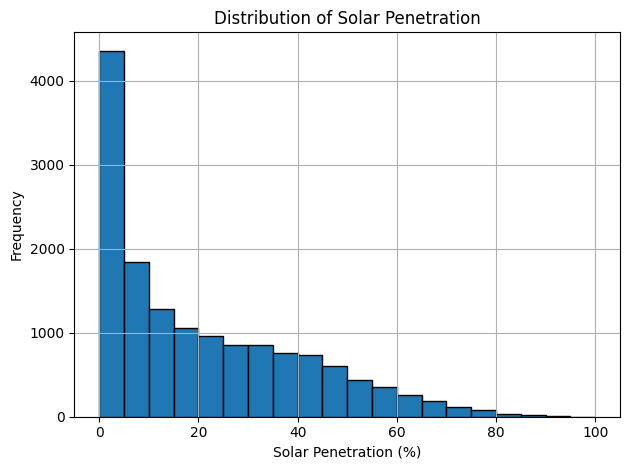

In [8]:
import matplotlib.pyplot as plt

plt.hist(df.solar_penetration, bins=20, range=(0, 100), edgecolor='black')
plt.xlabel('Solar Penetration (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Solar Penetration')
plt.grid(True)
plt.tight_layout()
plt.show()

       Bin Range  Count  Relative Frequency
0      0.0 – 5.0   4357            0.294970
1     5.0 – 10.0   1836            0.124298
2    10.0 – 15.0   1277            0.086453
3    15.0 – 20.0   1053            0.071288
4    20.0 – 25.0    958            0.064857
5    25.0 – 30.0    852            0.057681
6    30.0 – 35.0    848            0.057410
7    35.0 – 40.0    763            0.051655
8    40.0 – 45.0    729            0.049353
9    45.0 – 50.0    599            0.040552
10   50.0 – 55.0    442            0.029923
11   55.0 – 60.0    348            0.023560
12   60.0 – 65.0    260            0.017602
13   65.0 – 70.0    189            0.012795
14   70.0 – 75.0    110            0.007447
15   75.0 – 80.0     80            0.005416
16   80.0 – 85.0     38            0.002573
17   85.0 – 90.0     24            0.001625
18   90.0 – 95.0      6            0.000406
19  95.0 – 100.0      2            0.000135


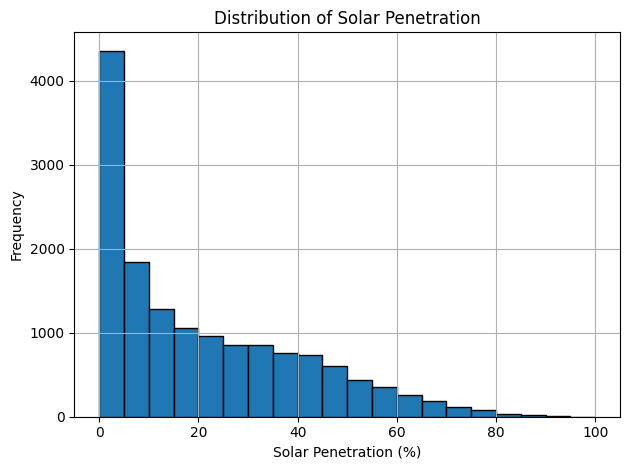

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate histogram data (same bins=20, range=(0, 100))
counts, bin_edges = np.histogram(df['solar_penetration'], bins=20, range=(0,100))

# Build a table: bin ranges and counts
hist_table = pd.DataFrame({
    'Bin Range': [f'{bin_edges[i]} – {bin_edges[i+1]}' for i in range(len(bin_edges)-1)],
    'Count': counts
})

# Optional: add relative frequencies
hist_table['Relative Frequency'] = hist_table['Count'] / hist_table['Count'].sum()

# Print the table
print(hist_table)

# If you still want to display the histogram as well:
plt.hist(df['solar_penetration'], bins=20, range=(0, 100), edgecolor='black')
plt.xlabel('Solar Penetration (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Solar Penetration')
plt.grid(True)
plt.tight_layout()
plt.show()

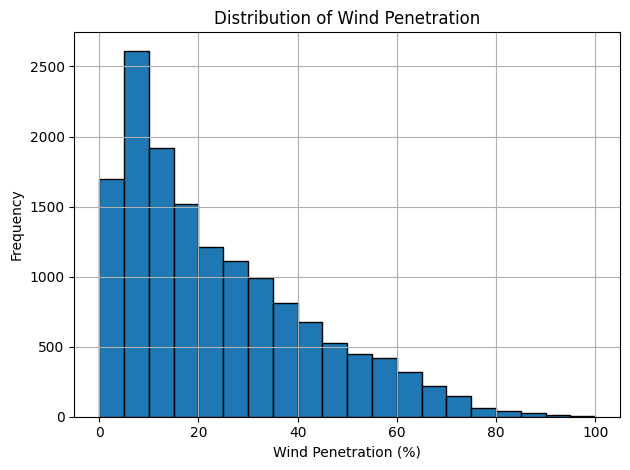

In [9]:
import matplotlib.pyplot as plt

plt.hist(df.wind_penetration, bins=20, range=(0, 100), edgecolor='black')
plt.xlabel('Wind Penetration (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Penetration')
plt.grid(True)
plt.tight_layout()
plt.show()

## total_penetration & renewable_penetration check

In [84]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
from tqdm import tqdm
import matplotlib.pyplot as plt


# Function to generate polynomial features up to a given order for two-dimensional input
def polynomial_features(x, order=1):
    n = x.size(0)
    features = [torch.ones(n)]
    for i in range(1, order + 1):
        for j in range(i + 1):
            features.append((x[:, 0]**(i-j)) * (x[:, 1]**j))
    return torch.cat([f.unsqueeze(1) for f in features], dim=1)


# Tri-cube weight function
def tri_cube(u):
    return torch.where(u < 1, (1 - u**3)**3, torch.zeros_like(u))


# Calculate weights for all points based on a fitting point and bandwidth
def calculate_weights(data_points, fitting_point, bandwidth):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    scaled_distances = distances / bandwidth
    weights = tri_cube(scaled_distances)
    return weights


# Perform weighted least squares regression (optimized)
def weighted_least_squares(X, y, weights):
    # Assume X is n x m and weights is n x 1
    weighted_X = X * weights.unsqueeze(1)  # element-wise multiplication to weight each row
    XTWX = weighted_X.T @ X  # This replaces the need for explicitly creating W
    XTWy = weighted_X.T @ y
    beta = torch.linalg.pinv(XTWX) @ XTWy
    return beta.squeeze()


# Calculate adaptive bandwidth based on the percentile of distances
def adaptive_bandwidth(data_points, fitting_point, percentile=40):
    if fitting_point.dim() == 1:
        fitting_point = fitting_point.unsqueeze(0)
    distances = torch.sqrt(torch.sum((data_points - fitting_point)**2, axis=1))
    return torch.quantile(distances, percentile / 100.0)


def process_data(data, covariates, response):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data[covariates] = scaler.fit_transform(data[covariates])
    
    features = torch.tensor(data[covariates].values, dtype=torch.float32)
    target = torch.tensor(data[response].values, dtype=torch.float32)
    
    return features, target, scaler


def fit_model(features, target, n_fitting_points=24):
    x = torch.linspace(-1, 1, n_fitting_points)
    y = torch.linspace(-1, 1, n_fitting_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    fitting_points = torch.column_stack([X.ravel(), Y.ravel()])
    
    X_poly_base = polynomial_features(features)
    
    coefficients = torch.zeros(len(fitting_points), X_poly_base.size(1), dtype=torch.float32)
    predicted_values = torch.zeros(len(fitting_points), dtype=torch.float32)
    
    for i, fp in enumerate(tqdm(fitting_points, desc="Fitting Points")):
        bandwidth = adaptive_bandwidth(features, fp, percentile=30)
        weights = calculate_weights(features, fp, bandwidth)
        X_poly = polynomial_features(fp.clone().detach().unsqueeze(0))
        beta = weighted_least_squares(X_poly_base, target, weights)
        coefficients[i] = beta
        predicted_values[i] = torch.matmul(X_poly, beta)
    
    return fitting_points, predicted_values


def plot_results(n_grid_points, fitting_points, predicted_values, scaler, filename, plane_zero=False):
    fitting_points = fitting_points.cpu()  # Transfer to CPU
    predicted_values = predicted_values.cpu()  # Transfer to CPU
    
    grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
    grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')
    
    original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
    original_grid_x = original_grid_x.reshape(grid_x.shape)
    original_grid_y = original_grid_y.reshape(grid_y.shape)
    
    fig = plt.figure(figsize=(6, 9), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap='plasma', edgecolor='k', linewidth=0.5)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap='plasma', alpha=0.7)
    contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap='plasma', alpha=0.7)
    
    # Add a plane for price zero
    if plane_zero:
        ax.plot_surface(original_grid_x, original_grid_y, np.zeros_like(original_grid_x), color='red', alpha=0.8, rstride=100, cstride=100)
    
    cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.5, aspect=40, pad=0.05, anchor=(0.5, 1.2))
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('Forecasted WP penetration (%)')
    ax.set_ylabel('Hour of the day')
    ax.set_zlabel('Price (GBP/MWh)')
    ax.set_zlim(-80, 250)
    plt.tight_layout()
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.85)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

Fitting Points: 100%|██████████| 576/576 [00:00<00:00, 1065.81it/s]


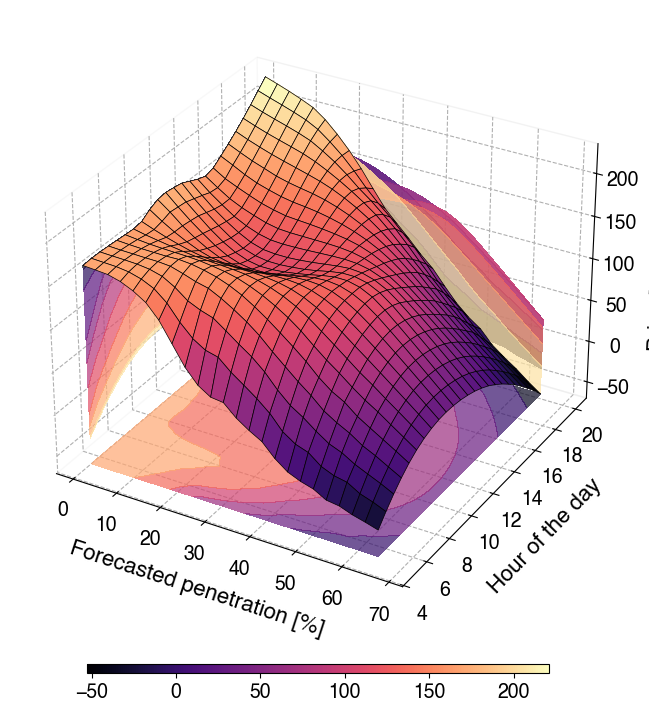

In [99]:
# from utils_mean import *
import matplotlib as mpl
import matplotlib.colors as mcolors

# Set plot aesthetics
mpl.rcParams.update({
    'font.family': 'Helvetica',  # Use Helvetica for clarity
    'axes.labelsize': 16,        # Larger axis labels
    'axes.titlesize': 16,        # Title font size
    'xtick.labelsize': 14,       # X-axis tick label size
    'ytick.labelsize': 14,       # Y-axis tick label size
    'legend.fontsize': 14,       # Legend font size
    'axes.grid': True,           # Enable grid
    'grid.alpha': 0.1,           # Subtle grid lines
    'grid.linestyle': '--',      # Dashed grid lines for a softer look
    'figure.dpi': 300,           # High DPI for high-quality figure
    'savefig.dpi': 300           # High DPI for saving the figure
})

df = pd.read_csv('data/causal_data.csv')
df = df[df['solar_penetration'] >= 1]
df = df[df['solar_penetration'] <= 65]
# df = df[df['Hour'] <= 18]
# df = df[df['Hour'] >= 6]

# Define covariates and response
covariates = ['solar_penetration', 'Hour']
response ='electricity_price'

# Process data
input_variables, target_variable, scaler = process_data(data=df, covariates=covariates, response=response)

# Fit models
fitting_points, predicted_values = fit_model(features=input_variables, target=target_variable, n_fitting_points=24)

# Plot results
n_grid_points = 24

fitting_points = fitting_points.cpu()  # Transfer to CPU
predicted_values = predicted_values.cpu()  # Transfer to CPU

grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')

original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
original_grid_x = original_grid_x.reshape(grid_x.shape)
original_grid_y = original_grid_y.reshape(grid_y.shape)

# colors_solar = ["#fff5e6", "#ff7f0e"]  # Light peach to orange
colors_solar = ["#ffd9b3", "#ff4500"]  # Light orange to reddish
n_bins = 100  # Number of bins for colormap
# cmap_solar = mcolors.LinearSegmentedColormap.from_list("solar_cmap", colors_solar, N=n_bins)
cmap_solar = 'magma'
# cmap_solar = 'Oranges'

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap=cmap_solar, edgecolor='k', linewidth=.5)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap=cmap_solar, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap=cmap_solar, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap=cmap_solar, alpha=0.7)

cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.6, aspect=50, pad=0.05)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('Forecasted penetration [%]', labelpad=10)
ax.set_ylabel('Hour of the day', labelpad=10)
ax.set_zlabel('Price [EUR/MWh]', labelpad=10)
# ax.set_zlim(-80, 200)
plt.tight_layout()
# plt.savefig(f'png/LWPR_solar.png',format='png', dpi=600)
plt.show()

In [26]:
df = pd.read_csv('data/causal_data.csv')
df.head()

,Date,solar_forecast,wind_off_forecast,wind_on_forecast,total_load,solar_capacity,wind_off_capacity,wind_on_capacity,electricity_price,daylight_hours,...,wind_capacity,solar_penetration,wind_penetration,solar_binary,Hour,Day,Month,Year,total_penetration,renewable_penetration
0,2022-01-01 00:00:00,0.0,23711.96,102410.79,169240.83,67479,8149,58014,50.05,8.04,...,66163,0.0,74.52,0,0,1,1,2022,74.52,74.52
1,2022-01-01 01:00:00,0.0,23338.32,98510.90,161676.38,67479,8149,58014,41.33,8.04,...,66163,0.0,75.37,0,1,1,1,2022,75.37,75.37
2,2022-01-01 02:00:00,0.0,22318.58,93902.99,156383.46,67479,8149,58014,43.22,8.04,...,66163,0.0,74.32,0,2,1,1,2022,74.32,74.32
3,2022-01-01 03:00:00,0.0,21115.75,89315.26,152266.20,67479,8149,58014,45.46,8.04,...,66163,0.0,72.52,0,3,1,1,2022,72.52,72.52
4,2022-01-01 04:00:00,0.0,19871.89,85151.19,152754.26,67479,8149,58014,37.67,8.04,...,66163,0.0,68.75,0,4,1,1,2022,68.75,68.75


In [38]:
df2 = df[df['solar_penetration'] != 0]

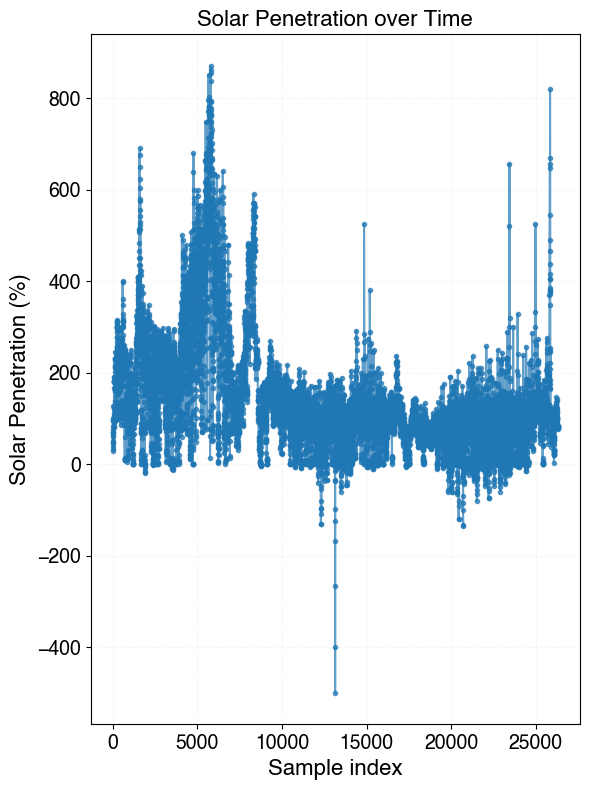

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 8), dpi=100)                  # width=6", height=8"
plt.plot(df['electricity_price'], marker='.', linestyle='-', alpha=0.7)
plt.title("Solar Penetration over Time")
plt.xlabel("Sample index")                  # or use your datetime index if you set one
plt.ylabel("Solar Penetration (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

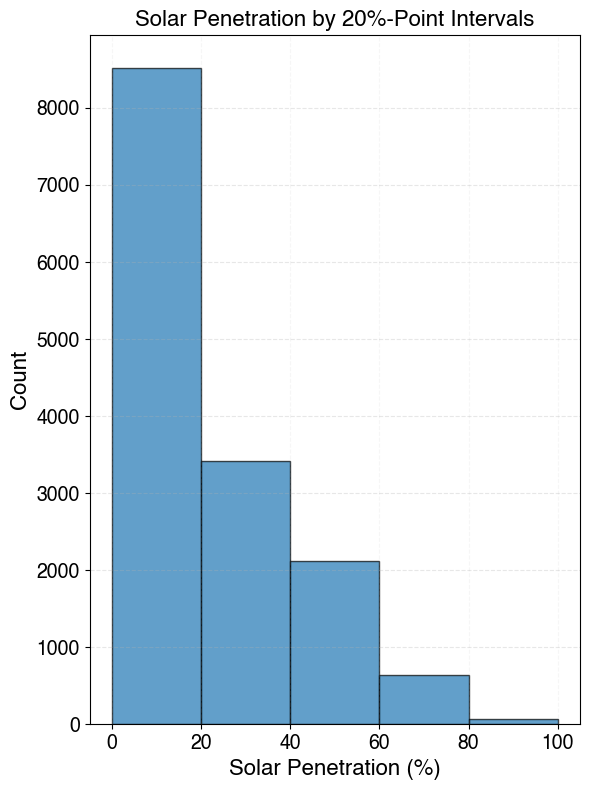

In [41]:
import numpy as np

# create edges at 0, 20, 40, ..., up to the max (rounded up to 100)
bins = np.arange(0, 101, 20)

plt.figure(figsize=(6, 8), dpi=100)
plt.hist(df2['solar_penetration'], bins=bins, edgecolor='k', alpha=0.7)
plt.xticks(bins)  # show the bin edges on the x-axis
plt.title("Solar Penetration by 20%-Point Intervals")
plt.xlabel("Solar Penetration (%)")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
df.electricity_price.describe()

count    14771.000000
mean       140.589446
std        124.222067
min       -500.000000
25%         72.030000
50%        106.200000
75%        172.275000
max        871.000000
Name: electricity_price, dtype: float64

## renewable_penetration

Fitting Points: 100%|██████████| 576/576 [00:01<00:00, 523.46it/s]


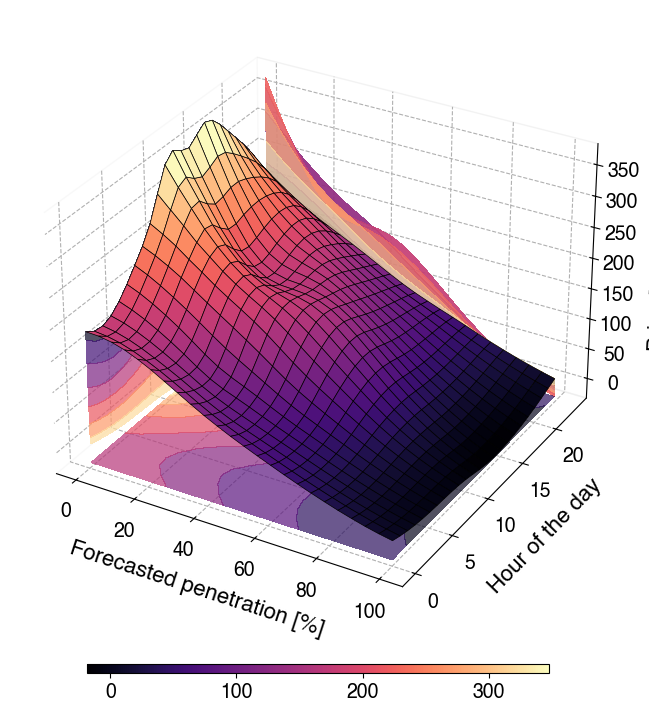

In [61]:
# from utils_mean import *
import matplotlib as mpl
import matplotlib.colors as mcolors

# Set plot aesthetics
mpl.rcParams.update({
    'font.family': 'Helvetica',  # Use Helvetica for clarity
    'axes.labelsize': 16,        # Larger axis labels
    'axes.titlesize': 16,        # Title font size
    'xtick.labelsize': 14,       # X-axis tick label size
    'ytick.labelsize': 14,       # Y-axis tick label size
    'legend.fontsize': 14,       # Legend font size
    'axes.grid': True,           # Enable grid
    'grid.alpha': 0.1,           # Subtle grid lines
    'grid.linestyle': '--',      # Dashed grid lines for a softer look
    'figure.dpi': 300,           # High DPI for high-quality figure
    'savefig.dpi': 300           # High DPI for saving the figure
})

df = pd.read_csv('data/causal_data.csv')
# df = df[df['solar_penetration'] != 0]
# df = df[df['solar_penetration'] >= 1]
# df = df[df['Hour'] <= 22]

# Define covariates and response
covariates = ['renewable_penetration', 'Hour']
response ='electricity_price'

# Process data
input_variables, target_variable, scaler = process_data(data=df, covariates=covariates, response=response)

# Fit models
fitting_points, predicted_values = fit_model(features=input_variables, target=target_variable, n_fitting_points=24)

# Plot results
n_grid_points = 24

fitting_points = fitting_points.cpu()  # Transfer to CPU
predicted_values = predicted_values.cpu()  # Transfer to CPU

grid_y, grid_x = np.meshgrid(np.linspace(-1, 1, n_grid_points), np.linspace(-1, 1, n_grid_points))
grid_z = griddata(fitting_points.numpy(), predicted_values.numpy(), (grid_x, grid_y), method='cubic')

original_grid_x, original_grid_y = scaler.inverse_transform(np.column_stack([grid_x.ravel(), grid_y.ravel()])).T
original_grid_x = original_grid_x.reshape(grid_x.shape)
original_grid_y = original_grid_y.reshape(grid_y.shape)

# colors_solar = ["#fff5e6", "#ff7f0e"]  # Light peach to orange
colors_solar = ["#ffd9b3", "#ff4500"]  # Light orange to reddish
n_bins = 100  # Number of bins for colormap
# cmap_solar = mcolors.LinearSegmentedColormap.from_list("solar_cmap", colors_solar, N=n_bins)
cmap_solar = 'magma'
# cmap_solar = 'Oranges'

fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(original_grid_x, original_grid_y, grid_z, cmap=cmap_solar, edgecolor='k', linewidth=.5)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='z', offset=np.min(grid_z), cmap=cmap_solar, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='x', offset=np.min(original_grid_x), cmap=cmap_solar, alpha=0.7)
contours = ax.contourf(original_grid_x, original_grid_y, grid_z, zdir='y', offset=np.max(original_grid_y), cmap=cmap_solar, alpha=0.7)

cbar = fig.colorbar(surface, orientation='horizontal', shrink=0.6, aspect=50, pad=0.05)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xlabel('Forecasted penetration [%]', labelpad=10)
ax.set_ylabel('Hour of the day', labelpad=10)
ax.set_zlabel('Price [EUR/MWh]', labelpad=10)
# ax.set_zlim(-80, 200)
plt.tight_layout()
# plt.savefig(f'png/LWPR_solar.png',format='png', dpi=600)
plt.show()